In [322]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import keras
import keras_tuner as kt
import torch

In [267]:
mps_device = torch.device("mps")

# Load Data

In [268]:
# Generate data paths with labels
data_dir = 'Data/Weather_Dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Filepath_series = pd.Series(filepaths, name= 'filepaths')
Label_series = pd.Series(labels, name='labels')
df = pd.concat([Filepath_series, Label_series], axis= 1)

df.head()


filepaths     labels
0  Data/Weather_Dataset/lightning/2100.jpg  lightning
1  Data/Weather_Dataset/lightning/2114.jpg  lightning
2  Data/Weather_Dataset/lightning/2128.jpg  lightning
3  Data/Weather_Dataset/lightning/1838.jpg  lightning
4  Data/Weather_Dataset/lightning/1964.jpg  lightning

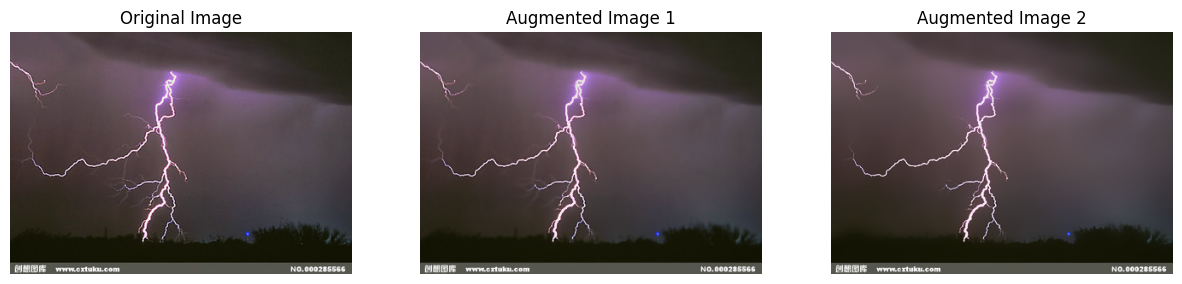

In [269]:
image = cv2.imread('Data/Weather_Dataset/lightning/2100.jpg')
augmented_image1 = cv2.bilateralFilter(image, 5, 75, 75)
augmented_image2 = cv2.bilateralFilter(image, 20, 50, 50)


# Display the images using matplotlib
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(augmented_image1)
plt.title("Augmented Image 1")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(augmented_image2)
plt.title("Augmented Image 2")
plt.axis('off')

plt.show()

# Delete corrupted image paths

In [270]:
num_skipped = 0
for folder_name in ('dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow'):
    folder_path = os.path.join("Data/Weather_Dataset", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


# First 5 Images per Class of Uncleaned Data

{'dew': [5111, 5112, 5113, 5114, 5115], 'fogsmog': [3753, 3754, 3755, 3756, 3757], 'frost': [3294, 3295, 3296, 3297, 3298], 'glaze': [1024, 1025, 1026, 1027, 1028], 'hail': [4550, 4551, 4552, 4553, 4554], 'lightning': [0, 1, 2, 3, 4], 'rain': [1655, 1656, 1657, 1658, 1659], 'rainbow': [5798, 5799, 5800, 5801, 5802], 'rime': [2157, 2158, 2159, 2160, 2161], 'sandstorm': [362, 363, 364, 365, 366], 'snow': [6025, 6026, 6027, 6028, 6029]}


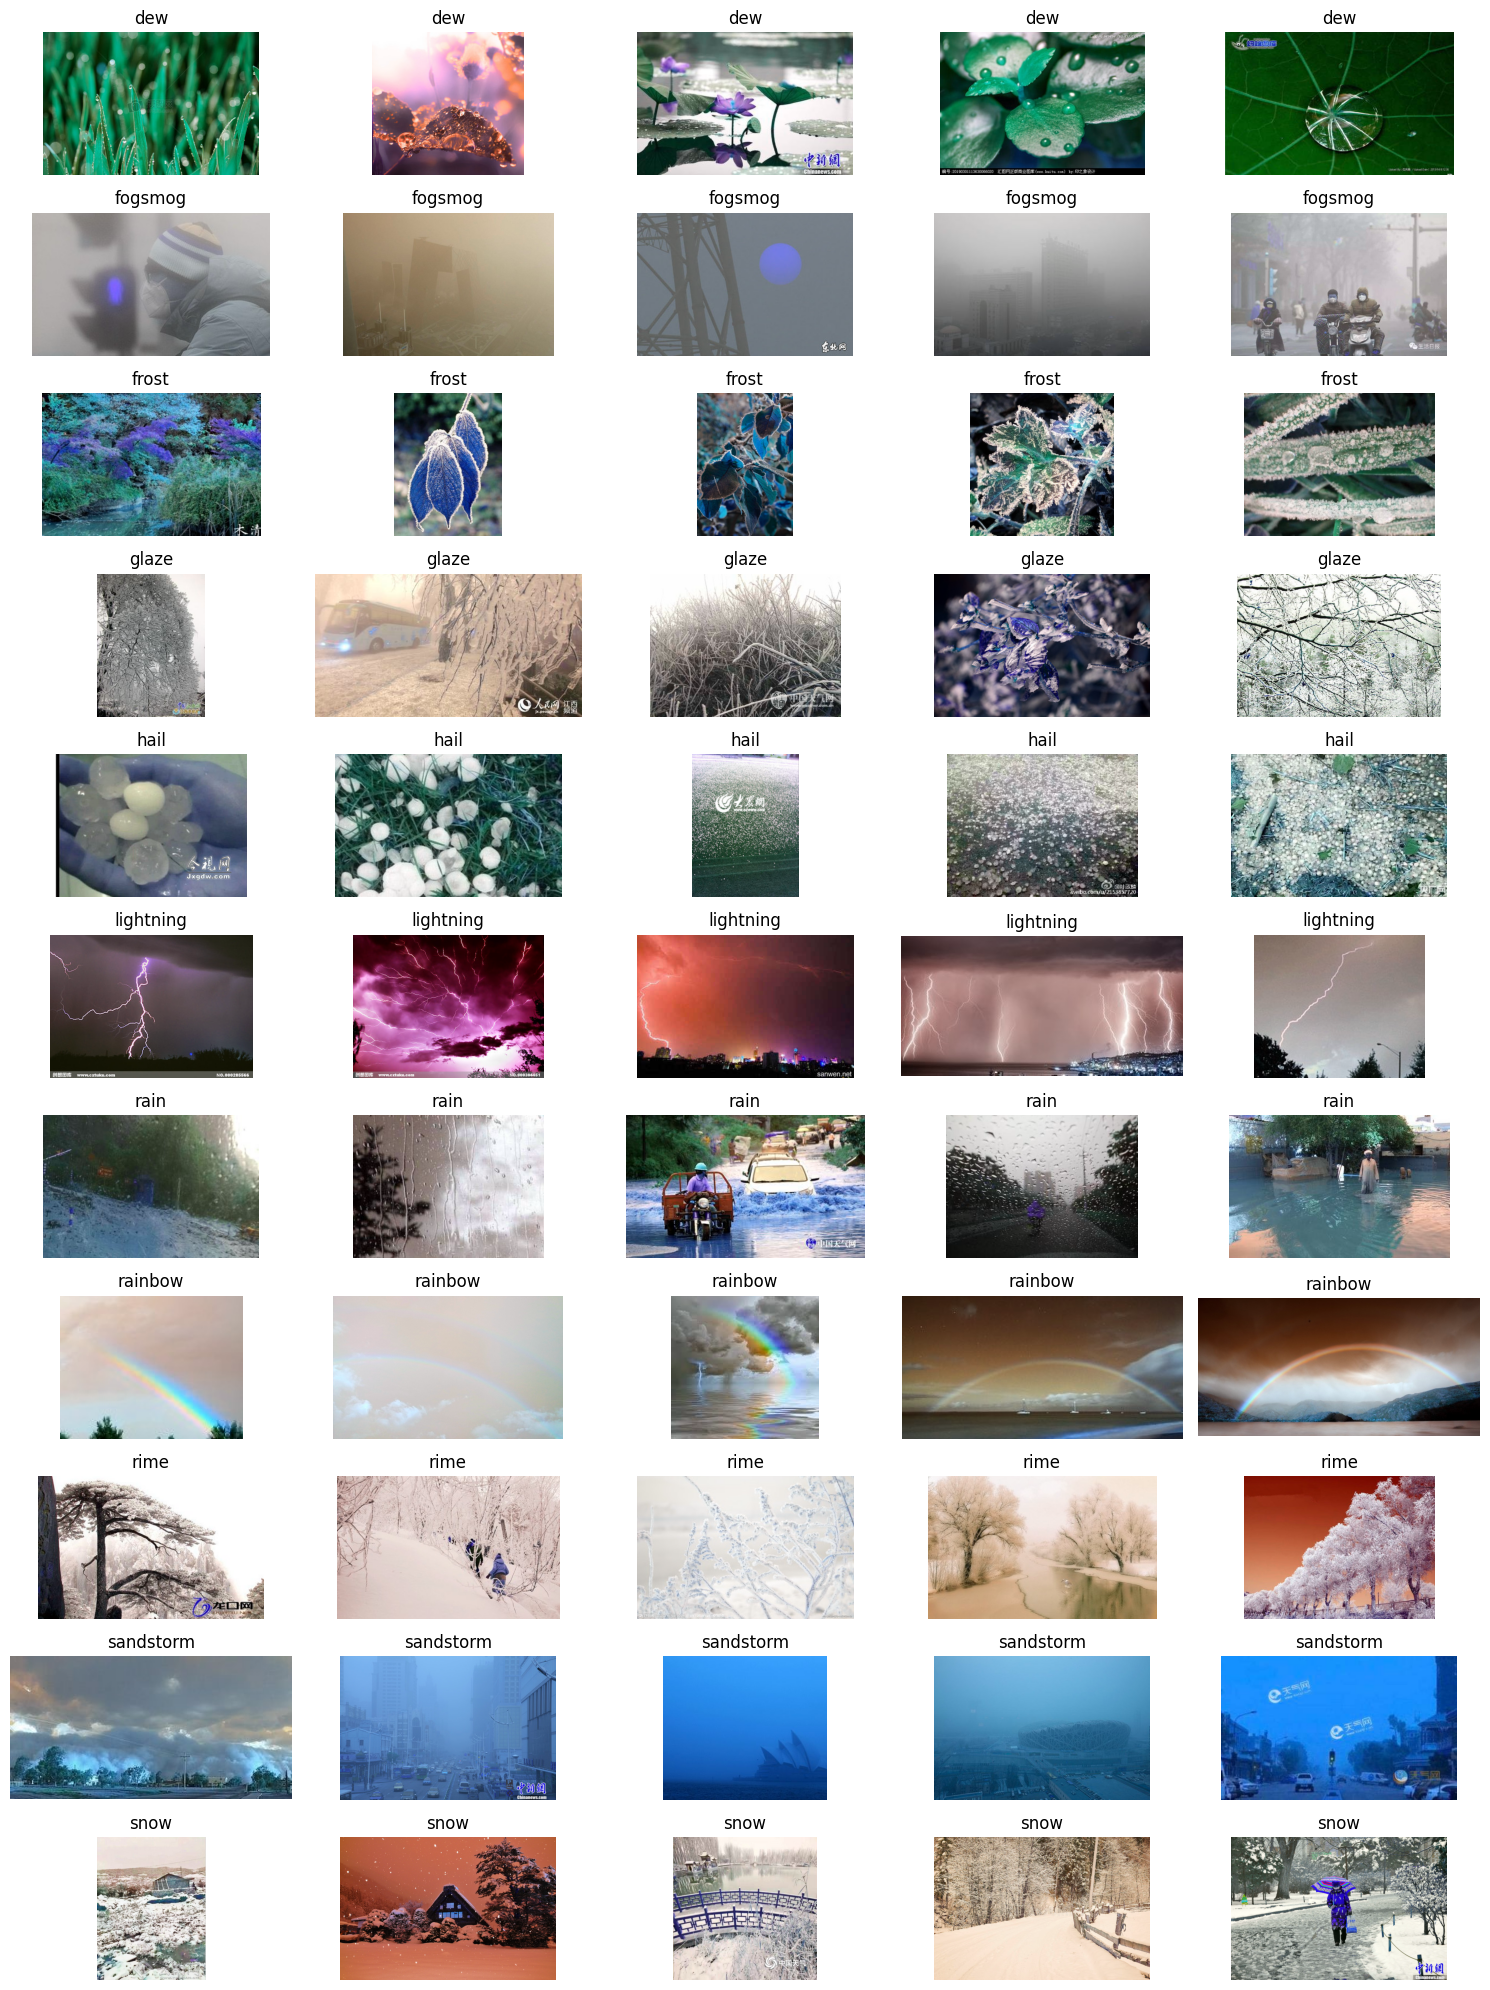

In [271]:
# Exploring first 5 images of each class from X_train
first_5_indeces_per_class = {i: [] for i in ('dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow')}
for index, label in enumerate(df['labels']):
    if len(first_5_indeces_per_class[label]) < 5:
        first_5_indeces_per_class[label].append(index)
    if all(len(first_5_indeces_per_class[i]) == 5 for i in ('dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow')):
        break

print(first_5_indeces_per_class)

fig, axes = plt.subplots(11, 5, figsize=(15, 20))
for i, label in enumerate(('dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow')):
    for j, index in enumerate(first_5_indeces_per_class[label]):
        axes[i, j].imshow(cv2.imread(df['filepaths'][index]))
        axes[i, j].set_title(label)
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

# Convert images to data

In [272]:
dew, fogsmog, frost, glaze, hail, lightning, rain, rainbow, rime, sandstorm, snow = [] ,[], [], [], [], [], [], [], [], [], []
labels = []
def process_images(folder, image_list):
    for image in os.listdir(folder):
        path = os.path.join(folder, image)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # change color from BGR to RGB
        img = cv2.copyMakeBorder(img, 50, 50, 50, 50, cv2.BORDER_CONSTANT, value=[255, 255, 255]) # add padding
        if img is not None:
            img = cv2.resize(img, (256, 256))
            image_list.append(img)
            labels.append(folder.split("/")[-1])
        else:
            print(f"Warning: Unable to read image {path}")

folders = ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
i = 0
for images in [dew, fogsmog, frost, glaze, hail, lightning, rain, rainbow, rime, sandstorm, snow]:
    process_images(str("Data/Weather_Dataset/" + folders[i]), images)
    i += 1

data = np.concatenate((np.asarray(dew),
                       np.asarray(fogsmog),
                       np.asarray(frost),
                       np.asarray(glaze),
                       np.asarray(hail),
                       np.asarray(lightning),
                       np.asarray(rain),
                       np.asarray(rainbow),
                       np.asarray(rime),
                       np.asarray(sandstorm),
                       np.asarray(snow)
                    ), axis=0)
print(data.shape)
print(len(labels))

(6604, 256, 256, 3)
6604


# Encode Labels

In [273]:
label_data = {'labels': labels}
label_data_df = pd.DataFrame(label_data)
encoder = OneHotEncoder()
encoded_labels = encoder.fit_transform(np.array(labels).reshape(-1,1)).toarray()
print(label_data_df.iloc[0], encoded_labels[0], encoder.inverse_transform(encoded_labels[0].reshape(1,-1))[0][0])
encoded_labels

labels    dew
Name: 0, dtype: object [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] dew


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

# Shuffle Data and Split to Train and Test sets

In [274]:
np.random.seed(1234)
shuffled_indices = np.random.permutation(range(len(data)))
X = data[shuffled_indices]
Y = encoded_labels[shuffled_indices]
print(f"X.shape: {X.shape}")
print(f"Y.shape: {Y.shape}")


X.shape: (6604, 256, 256, 3)
Y.shape: (6604, 11)


In [277]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.4, random_state=1234)
X_test, X_val, Y_test, Y_val = train_test_split(X_val, Y_val, test_size=0.5, random_state=1234)

# Part 2, print the shape of each
print(f"X_train.shape: {X_train.shape}\tY_train.shape: {Y_train.shape}")
print(f"X_val.shape: {X_val.shape}\tY_val.shape: {Y_val.shape}")
print(f"X_test.shape: {X_test.shape}\tY_test.shape: {Y_test.shape}")

X_train.shape: (3962, 256, 256, 3)	Y_train.shape: (3962, 11)
X_val.shape: (1321, 256, 256, 3)	Y_val.shape: (1321, 11)
X_test.shape: (1321, 256, 256, 3)	Y_test.shape: (1321, 11)


# Normalize and Scale Images

In [278]:
# check max and min pixel values
print(np.max(X_train), np.min(X_train))

255 0


In [279]:
scaler = MinMaxScaler() # scale pixel values between 0 and 1
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_train.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_train.shape[-1])).reshape(X_test.shape)

X_train = X_train.reshape(X_train.shape[0], 256,256,3)
X_val = X_val.reshape(X_val.shape[0], 256,256,3)
X_test = X_test.reshape(X_test.shape[0], 256,256,3)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3962, 256, 256, 3)
(1321, 256, 256, 3)
(1321, 256, 256, 3)


# Data Exploration of Training Dataset

       labels  count
0        rime    714
1     fogsmog    476
2   sandstorm    409
3         dew    399
4       glaze    363
5        hail    352
6        snow    338
7        rain    306
8       frost    259
9   lightning    198
10    rainbow    148


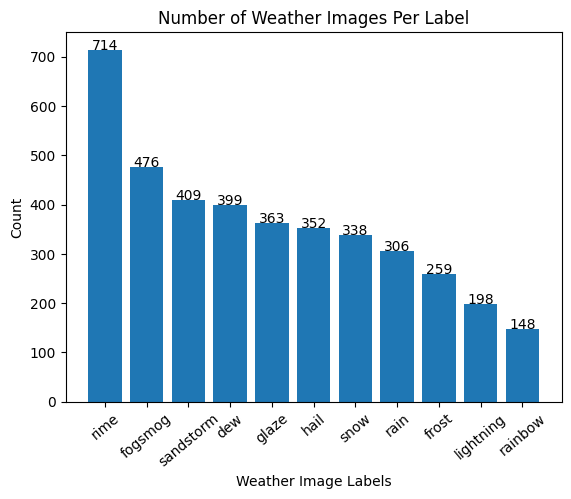

In [280]:
# Number of images per  class
decoded_labels = encoder.inverse_transform(Y_train)

counts = pd.DataFrame(decoded_labels).value_counts().to_frame().reset_index()
counts.columns = ['labels', 'count']
print(counts)

# Plot the distribution of the labels
plt.bar(counts['labels'], counts['count'])
for i in range(len(counts)):
    plt.text(i, counts['count'][i], counts['count'][i], ha = 'center')
plt.title("Number of Weather Images Per Label")
plt.xlabel("Weather Image Labels")
plt.xticks(rotation=40)
plt.ylabel("Count")
plt.show()

{'dew': [1, 7, 16, 25, 59], 'fogsmog': [18, 22, 49, 52, 97], 'frost': [8, 33, 71, 84, 88], 'glaze': [0, 20, 34, 57, 61], 'hail': [6, 10, 12, 15, 28], 'lightning': [9, 27, 126, 141, 143], 'rain': [50, 54, 56, 70, 92], 'rainbow': [21, 32, 38, 46, 120], 'rime': [3, 17, 19, 24, 26], 'sandstorm': [2, 4, 5, 11, 23], 'snow': [13, 14, 41, 47, 53]}


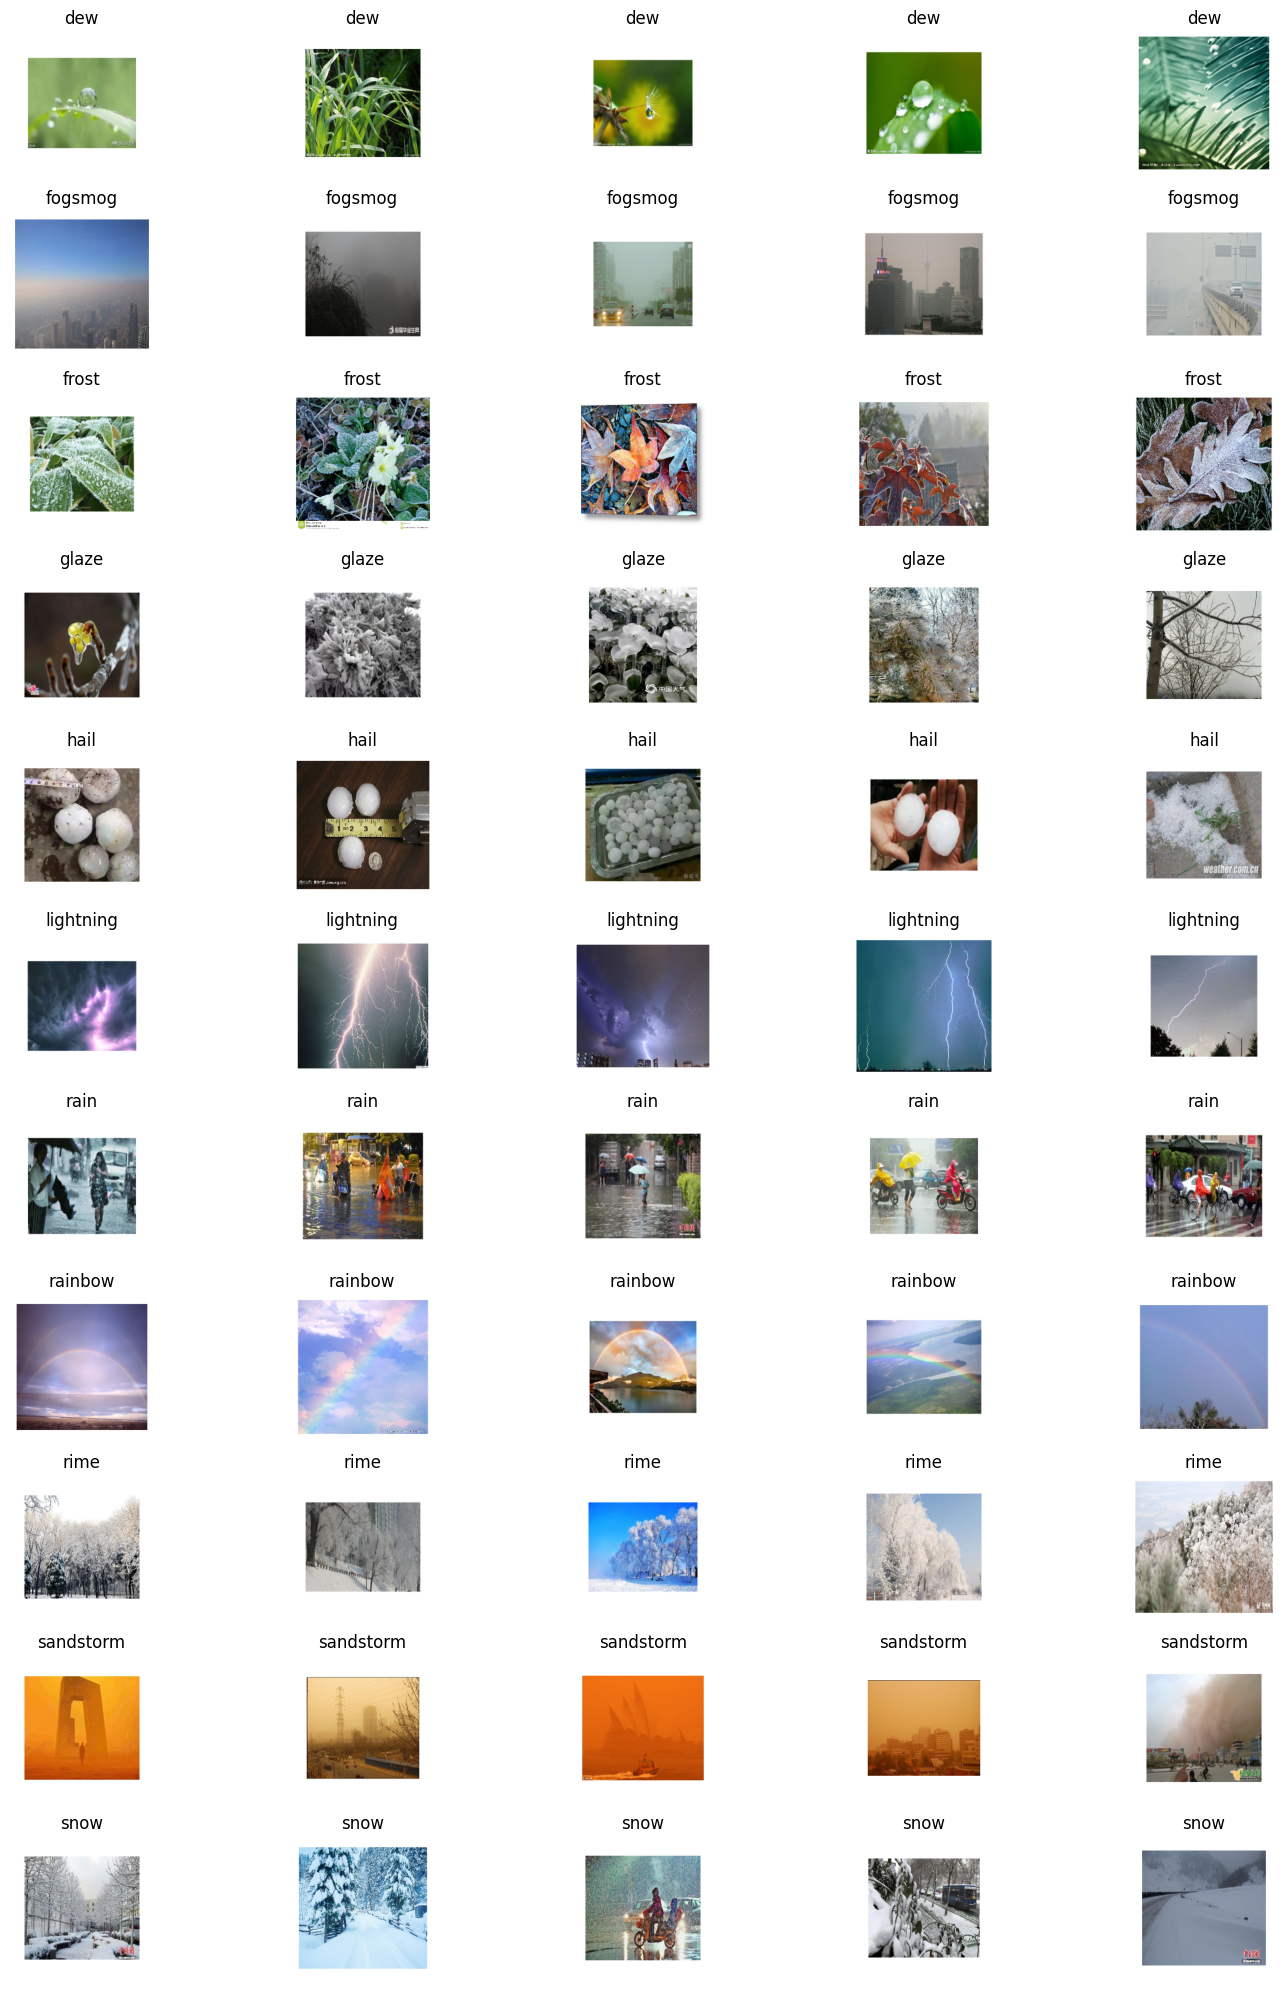

In [281]:
# Exploring first 5 images of each class from shuffled X_train
first_5_indeces_per_class = {i: [] for i in encoder.categories_[0]}
for index, label in enumerate(Y_train):
    label = encoder.inverse_transform(label.reshape(1,-1))[0][0]
    if len(first_5_indeces_per_class[label]) < 5:
        first_5_indeces_per_class[label].append(index)
    if all(len(first_5_indeces_per_class[i]) == 5 for i in encoder.categories_[0]):
        break

print(first_5_indeces_per_class)

fig, axes = plt.subplots(11, 5, figsize=(15, 20))
for i, label in enumerate(encoder.categories_[0]):
    for j, index in enumerate(first_5_indeces_per_class[label]):
        axes[i, j].imshow(X_train[index].reshape(256, 256,3))
        axes[i, j].set_title(label)
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

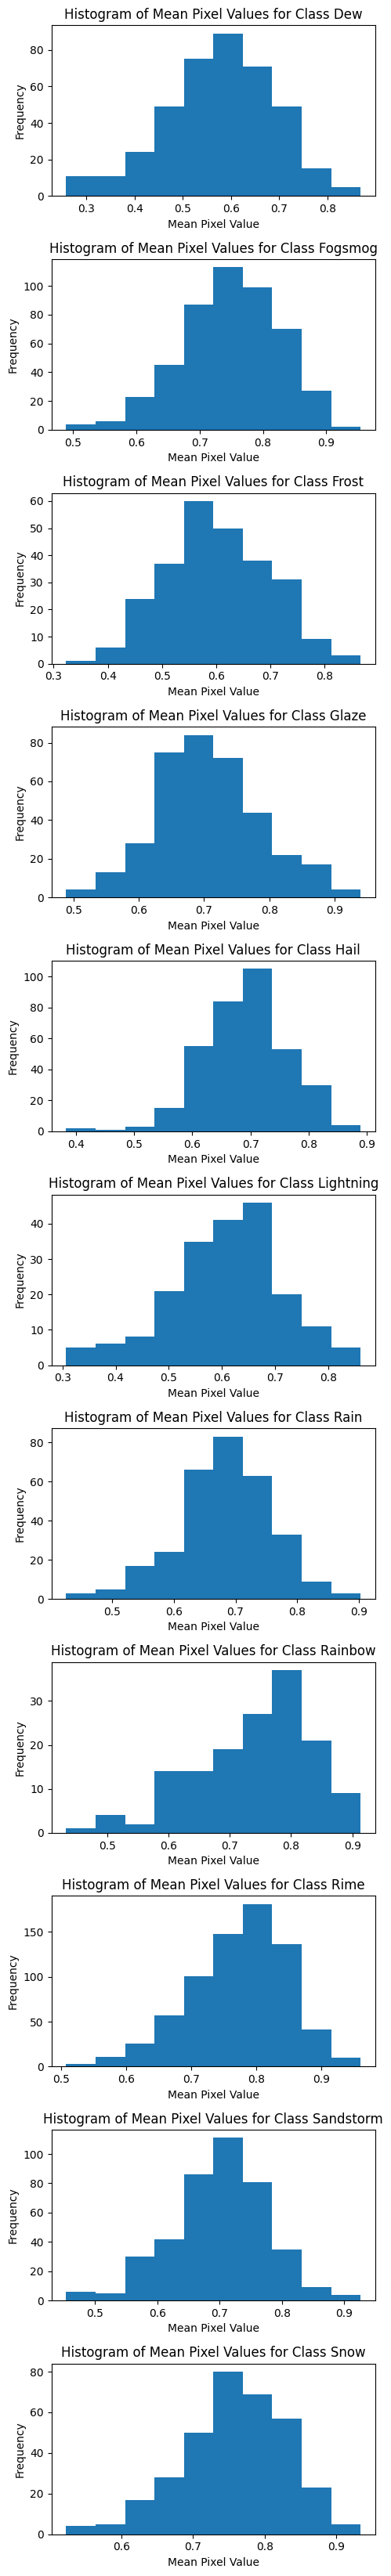

The mean pixel value across all images in class 0 is 0.5753254171534522.
The mean pixel value across all images in class 1 is 0.7484096203394042.
The mean pixel value across all images in class 2 is 0.6016910977796418.
The mean pixel value across all images in class 3 is 0.7063349186956639.
The mean pixel value across all images in class 4 is 0.6909995008775752.
The mean pixel value across all images in class 5 is 0.6101404632429341.
The mean pixel value across all images in class 6 is 0.6828780238175872.
The mean pixel value across all images in class 7 is 0.7388244552086698.
The mean pixel value across all images in class 8 is 0.7732316464454705.
The mean pixel value across all images in class 9 is 0.69994805452417.
The mean pixel value across all images in class 10 is 0.7582195258525066.


In [ ]:
#  Initialize lists to store mean pixel values for each class
mean_pixel_values = [[] for _ in encoder.categories_[0]]

# Calculate mean pixel values for each class
for i in range(len(Y_train)):
    class_label = encoder.inverse_transform(Y_train[i].reshape(1,-1))[0][0]
    for label in range(len(encoder.categories_[0])):
        if class_label == encoder.categories_[0][label]:
            mean_pixel_values[label].append(np.mean(X_train[i]))

# Create subplots
fig, axes = plt.subplots(len(encoder.categories_[0]), 1, figsize=(5, 3 * len(encoder.categories_[0])))

# Plot histograms for each class
for class_label in range(len(encoder.categories_[0])):
    axes[class_label].hist(mean_pixel_values[class_label])
    axes[class_label].set_title(f"Histogram of Mean Pixel Values for Class {encoder.categories_[0][class_label].title()}")
    axes[class_label].set_xlabel("Mean Pixel Value")
    axes[class_label].set_ylabel("Frequency")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Print mean pixel value for each class
for class_label in range(len(encoder.categories_[0])):
    print(f"The mean pixel value across all images in class {class_label} is {np.mean(mean_pixel_values[class_label])}.")

# Baseline Logistic Regression with TensorFlow

In [283]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Part 3, print the shape of X_train and X_test
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3962, 196608)
(1321, 196608)
(1321, 196608)


In [284]:
def build_model(num_features, learning_rate):
  """Build a TF logistic regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # binary logistic regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=11,                     # output dim
      input_shape=[num_features],  # input dim
      use_bias=True,               # use a bias (intercept) param
      activation='softmax',     # softmax activation function for mutliclass classification
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch GD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
  model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['categorical_accuracy'])  # Categorical cross entropy (multiclass log loss)

  return model

In [291]:
tf.random.set_seed(1234)
# Build and compile model
model_tf = build_model(X_train.shape[1], learning_rate=0.0001)

model_tf_history = model_tf.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_val, Y_val))

/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - categorical_accuracy: 0.2241 - loss: 2.2258 - val_categorical_accuracy: 0.3467 - val_loss: 1.8422
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - categorical_accuracy: 0.4147 - loss: 1.7578 - val_categorical_accuracy: 0.4027 - val_loss: 1.6974
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - categorical_accuracy: 0.4681 - loss: 1.6109 - val_categorical_accuracy: 0.4459 - val_loss: 1.6155
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - categorical_accuracy: 0.4978 - loss: 1.5327 - val_categorical_accuracy: 0.4580 - val_loss: 1.5775
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - categorical_accuracy: 0.5119 - loss: 1.4827 - val_categorical_accuracy: 0.4769 - val_loss: 1.5401
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.5281 - loss: 1.4466 - val_categorical_accuracy: 0.4852 - val_loss: 1.5210
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - categorical_accuracy: 0.5

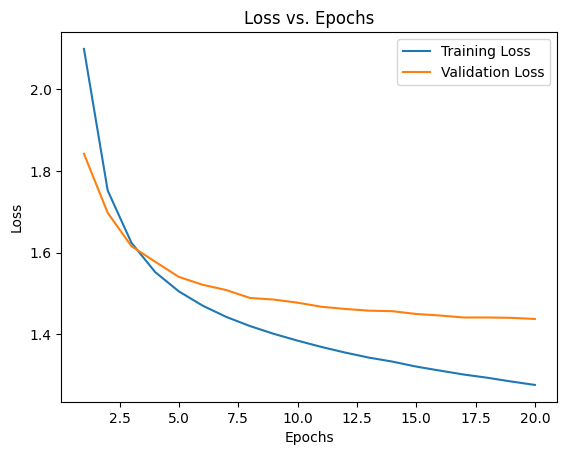

In [292]:
training_loss = model_tf_history.history['loss']
validation_loss = model_tf_history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Evaluate the Model

In [293]:
train_loss = model_tf.evaluate(X_train, Y_train)
val_loss = model_tf.evaluate(X_val, Y_val)

print(f"Training loss: {train_loss}")
print(f"Validation loss: {val_loss}")

124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - categorical_accuracy: 0.5799 - loss: 1.2838
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - categorical_accuracy: 0.5144 - loss: 1.4086
Training loss: [1.29403555393219, 0.5648662447929382]
Validation loss: [1.437059998512268, 0.5162755250930786]


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1321 1321


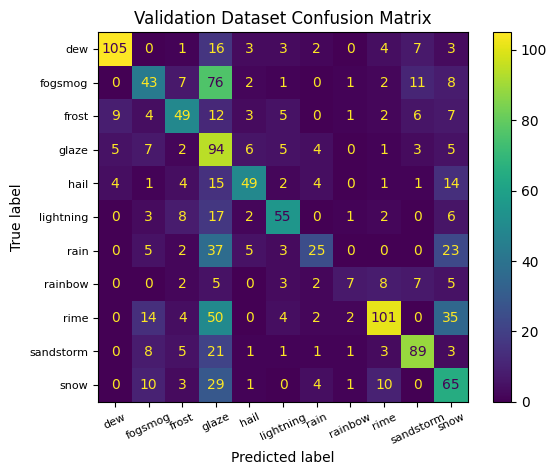

Len of X_val: 1321


In [294]:
Y_val_pred = model_tf.predict(x=X_val)
Y_val_labels = np.argmax(Y_val, axis=1)
# Get the class with the highest probability for each sample
Y_val_pred_classes = np.argmax(Y_val_pred, axis=1)
print(len(Y_val_labels), len(Y_val_pred_classes))
conf_matrix=confusion_matrix(Y_val_labels, Y_val_pred_classes)
# Plot confusion matrix
plot_labels = [f"{encoder.categories_[0][i]}" for i in range(11)]
display = ConfusionMatrixDisplay(conf_matrix, display_labels=plot_labels)
display.plot()
plt.title("Validation Dataset Confusion Matrix")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8, rotation=25)
plt.show()

# Printing True Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN)
print(f"Len of X_val: {len(X_val)}")



# Subgroup Accuracy

In [328]:
# YOUR CODE HERE
# Get true class label indices
def subgroup_accuracy(labels, preds):
    print(f"Overall model accuracy score: {accuracy_score(labels, preds)}")
    print(f"Overall model precision score: {precision_score(labels, preds, average='macro')}")
    print(f"Overall model recall score: {recall_score(labels, preds, average='macro')}")
    print(f"Overall model F1 score: {f1_score(labels, preds, average='macro')}\n")
    
    subgroup_accuracies = {}
    for i in np.unique(labels):
        # Get true label indices
        class_label_indices = np.where(labels == i)[0]
        # Get predicted labels for those indices
        class_label_preds = preds[class_label_indices]
        # Calculate accuracy for this class
        class_label_accuracy = len(np.where(class_label_preds==i)[0]) / len(class_label_indices)
        # Get the name of the class label
        one_hot_vector = np.eye(len(encoder.categories_[0]))[i].reshape(1, -1)
        class_label_name = encoder.inverse_transform(one_hot_vector)[0][0]
        # Add to dictionary
        subgroup_accuracies[f"Subgroup accuracy for {class_label_name}"] = np.round(class_label_accuracy,2)
    
    # Sort subgroup accuracies and print
    subgroup_accuracies = dict(sorted(subgroup_accuracies.items(), key=lambda x: x[1], reverse=True))
    for label, accuracy in subgroup_accuracies.items():
        print(f"{label}: {accuracy}")
    
print("Validation dataset evaluation metrics:\n")
subgroup_accuracies = subgroup_accuracy(Y_val_labels, np.argmax(Y_val_pred,axis=1))

Validation dataset evaluation metrics:

Overall model accuracy score: 0.5162755488266465
Overall model precision score: 0.5806092960539134
Overall model recall score: 0.4936802216438016
Overall model F1 score: 0.5069261760036552

Subgroup accuracy for dew: 0.73
Subgroup accuracy for glaze: 0.71
Subgroup accuracy for sandstorm: 0.67
Subgroup accuracy for lightning: 0.59
Subgroup accuracy for snow: 0.53
Subgroup accuracy for hail: 0.52
Subgroup accuracy for frost: 0.5
Subgroup accuracy for rime: 0.48
Subgroup accuracy for fogsmog: 0.28
Subgroup accuracy for rain: 0.25
Subgroup accuracy for rainbow: 0.18


In [330]:
print(classification_report(Y_val_labels, np.argmax(Y_val_pred, axis=1), target_names=np.unique(decoded_labels)))

              precision    recall  f1-score   support

         dew       0.85      0.73      0.79       144
     fogsmog       0.45      0.28      0.35       151
       frost       0.56      0.50      0.53        98
       glaze       0.25      0.71      0.37       132
        hail       0.68      0.52      0.59        95
   lightning       0.67      0.59      0.62        94
        rain       0.57      0.25      0.35       100
     rainbow       0.50      0.18      0.26        39
        rime       0.75      0.48      0.58       212
   sandstorm       0.72      0.67      0.69       133
        snow       0.37      0.53      0.44       123

    accuracy                           0.52      1321
   macro avg       0.58      0.49      0.51      1321
weighted avg       0.59      0.52      0.53      1321



## Feed Forward Neural Network